In [1]:
import utility_module_2_v_3 as uu
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
from numpy import meshgrid
from mpl_toolkits.basemap import Basemap

import geopandas as gpd
from shapely.geometry  import Point
from shapely.geometry import shape
import seaborn as sns
import pandas as pd 


In [2]:
gcm_iter = 1
gcm_names=['MIROC_ESM','CanESM2','HadGEM_AO','GFDL_CM3']
gcm_name=gcm_names[gcm_iter]
gcm_name

'CanESM2'

In [3]:

def map_plot_cyl(data_lat_x_lon,lat_cen,lon_cen,map_bounds,clab,cmap,y_limit,ax,mp_spacing=10,subplot_iter=1,loff=1,ex='both'):

  lat_box=uu.cen_to_box(lat_cen)
  lon_box=uu.cen_to_box(lon_cen)

  map = Basemap(projection='cyl',resolution='l',
                llcrnrlon=map_bounds[0], 
                urcrnrlat=map_bounds[1],
                urcrnrlon=map_bounds[2], 
                llcrnrlat=map_bounds[3])


  xx, yy = meshgrid(lon_box,lat_box )
  #return  dimenion of lat * lon
  map.pcolor(xx, yy, data_lat_x_lon,cmap=cmap)
  map.drawmeridians(np.arange(-180,180,mp_spacing),labels=[0,0,0,1], linewidth=1.0) #longitudes
  if loff==0:
    map.drawparallels(np.arange(-90,90,mp_spacing),labels=[1,0,0,0], linewidth=1.0) #latitudes
  else:
    map.drawparallels(np.arange(-90,90,mp_spacing),labels=[0,0,0,0], linewidth=1.0) #latitudes
  cbar = map.colorbar(extend=ex)
  #cbar.ax.set_yticklabels(['0','1','2','>3'])
  cbar.set_label(clab, rotation=90)
  #map.drawcountries(linewidth=1)
  map.readshapefile('/home/vikram/BCSD_Shapefiles/ind', 'IND', linewidth=1.0)

  map.drawcoastlines(linewidth=1)
  lxx=0.05
  lyy=0.92
  lcol='k'
  lsize=24
  lfamily='Tahoma'
  lweight=800
 # y_limit=[0,30]
  #clab='days'
  
  plt.clim(y_limit)
  plt.text(lxx, lyy, chr(subplot_iter+96), horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontweight=lweight,
           fontfamily=lfamily,fontsize=lsize,color=lcol)


In [4]:
def create_mask(fo,lat_obs_cru,lon_obs_cru,buffer=0,plot=0):
  filename=gpd.read_file(fo)
  shp_geom = shape(filename.geometry[0])

  xxc, yyc = meshgrid(lon_obs_cru,lat_obs_cru)
  mask_shape=np.zeros(xxc.shape,dtype=bool)
  if plot==1:
    x,y = shp_geom.exterior.xy
    plt.plot(x,y)
  N1=xxc.shape[0]
  N2=xxc.shape[1]

  for lat_i in range(0,N1):
    for lon_i in range(0,N2):
      xi=xxc[lat_i,lon_i]
      yi=yyc[lat_i,lon_i]
      m1= (shp_geom.contains(Point(xi, yi)) or shp_geom.touches(Point(xi, yi)))
      mask_shape[lat_i,lon_i]=not m1

  return mask_shape

In [5]:
def correct_nan_inf_neg_sts(data_prec):
    data_prec[data_prec<0]=0

    data_prec[np.isnan(data_prec)]=0

    data_prec[np.isinf(data_prec)]=0  
    
    import copy
    _,N1,N2 = data_prec.shape

    for n1 in range(N1):
        for n2 in range(N2):
            temp = copy.deepcopy(data_prec[:,n1,n2])
            temp[np.isinf(temp)] = np.nan
            data_prec[np.isinf(data_prec[:,n1,n2]),n1,n2]   =  np.nanmax(temp)
    del temp
    return data_prec 



## indices

In [6]:
import numpy as np
import scipy.stats
def mean_sp(daily_ts):
  
  return daily_ts.mean(axis=0)


def mean_sp_annualy(daily_ts,st,en):
  CDD_year=np.zeros((en-st+1))
  days_iter=0
  for yeaR in range(en-st+1):
    daily_year_ts=daily_ts[days_iter:days_iter+uu.isleapyear(st)+365]
    CDD_year[yeaR]=mean_sp(daily_year_ts)
    days_iter=days_iter+uu.isleapyear(st)+365
  return CDD_year


def mean_sp_annualy_ly(daily_ts,st,en):
  CDD_year=np.zeros((en-st+1))
  days_iter=0
  for yeaR in range(en-st+1):
    daily_year_ts=daily_ts[days_iter:days_iter+365]
    CDD_year[yeaR]=mean_sp(daily_year_ts)
    days_iter=days_iter+365
  return CDD_year




def CDD(daily_ts):
  N=daily_ts.shape[0]
  #print(N)
  cdd_max=0
  i=0
  while(True):
    if i>=N:
      break
    else:
      cdd=0
      #print("outer")
      while(True):
        
        if daily_ts[i]<1 :
          cdd=cdd+1
          #print(cdd,i,daily_ts[i])
          i=i+1
          if i+1>N:
            break;
        else:
          #print(-1,i,daily_ts[i])
          i=i+1
          break
      cdd_max=max(cdd, cdd_max)
      
  return cdd_max


def CDD_annualy(daily_ts,st,en):
  CDD_year=np.zeros((en-st+1))
  days_iter=0
  for yeaR in range(en-st+1):
    daily_year_ts=daily_ts[days_iter:days_iter+uu.isleapyear(st)+365]
    CDD_year[yeaR]=CDD(daily_year_ts)
    days_iter=days_iter+uu.isleapyear(st)+365
  return CDD_year

def CDD_annualy_ly(daily_ts,st,en):
  CDD_year=np.zeros((en-st+1))
  days_iter=0
  for yeaR in range(en-st+1):
    daily_year_ts=daily_ts[days_iter:days_iter+365]
    CDD_year[yeaR]=CDD(daily_year_ts)
    days_iter=days_iter+365
  return CDD_year


def CWD(daily_ts):
  N=daily_ts.shape[0]
  #print(N)
  cwd_max=0
  i=0
  while(True):
    if i>=N:
      break
    else:
      cwd=0
      #print("outer")
      while(True):
        
        if daily_ts[i]>=1 :
          cwd=cwd+1
          #print(cwd,i,daily_ts[i])
          i=i+1
          if i+1>N:
            break;
        else:
          #print(-1,i,daily_ts[i])
          i=i+1
          break
      cwd_max=max(cwd, cwd_max)
      
  return cwd_max

def CWD_annualy(daily_ts,st,en):
  CWD_year=np.zeros((en-st+1))
  days_iter=0
  for yeaR in range(en-st+1):
    daily_year_ts=daily_ts[days_iter:days_iter+uu.isleapyear(st)+365]
    CWD_year[yeaR]=CWD(daily_year_ts)
    days_iter=days_iter+uu.isleapyear(st)+365
  return CWD_year

def Rx1day(daily_ts):
  return np.max(daily_ts)

def Rx1day_annualy(daily_ts,st,en):
  Rx1day_year=np.zeros((en-st+1))
  days_iter=0
  for yeaR in range(en-st+1):
    daily_year_ts=daily_ts[days_iter:days_iter+uu.isleapyear(st)+365]
    Rx1day_year[yeaR]=Rx1day(daily_year_ts)
    days_iter=days_iter+uu.isleapyear(st)+365
  return Rx1day_year

def Rx1day_annualy_ly(daily_ts,st,en):
  Rx1day_year=np.zeros((en-st+1))
  days_iter=0
  for yeaR in range(en-st+1):
    daily_year_ts=daily_ts[days_iter:days_iter+365]
    Rx1day_year[yeaR]=Rx1day(daily_year_ts)
    days_iter=days_iter+365
  return Rx1day_year

def Rx5day(daily_ts):
  N=np.shape(daily_ts)[0]
  sum_max=0
  for i in range(N-4):
    summ=np.sum(daily_ts[i:i+5])
    sum_max=max(sum_max,summ)

  return sum_max

def Rx5day_annualy(daily_ts,st,en):
  Rx5day_year=np.zeros((en-st+1))
  days_iter=0
  for yeaR in range(en-st+1):
    daily_year_ts=daily_ts[days_iter:days_iter+uu.isleapyear(st)+365]
    Rx5day_year[yeaR]=Rx5day(daily_year_ts)
    days_iter=days_iter+uu.isleapyear(st)+365
  return Rx5day_year

def Rx5day_annualy_ly(daily_ts,st,en):
  Rx5day_year=np.zeros((en-st+1))
  days_iter=0
  for yeaR in range(en-st+1):
    daily_year_ts=daily_ts[days_iter:days_iter+365]
    Rx5day_year[yeaR]=Rx5day(daily_year_ts)
    days_iter=days_iter+365
  return Rx5day_year


def SDII(daily_ts):
  sum_RR=np.sum(daily_ts[daily_ts>=1])
  W=np.sum([daily_ts>=1])
  return sum_RR/W


def SDII_annualy(daily_ts,st,en):
  SDII_year=np.zeros((en-st+1))
  days_iter=0
  for yeaR in range(en-st+1):
    daily_year_ts=daily_ts[days_iter:days_iter+uu.isleapyear(st)+365]
    SDII_year[yeaR]=SDII(daily_year_ts)
    days_iter=days_iter+uu.isleapyear(st)+365
  return SDII_year


def R10mm(daily_ts):
  return np.sum([daily_ts>=10])

def R10mm_annualy(daily_ts,st,en):
  R10mm_year=np.zeros((en-st+1))
  days_iter=0
  for yeaR in range(en-st+1):
    daily_year_ts=daily_ts[days_iter:days_iter+uu.isleapyear(st)+365]
    R10mm_year[yeaR]=R10mm(daily_year_ts)
    days_iter=days_iter+uu.isleapyear(st)+365
  return R10mm_year


def R10mm_annualy_ly(daily_ts,st,en):
  R10mm_year=np.zeros((en-st+1))
  days_iter=0
  for yeaR in range(en-st+1):
    daily_year_ts=daily_ts[days_iter:days_iter+365]
    R10mm_year[yeaR]=R10mm(daily_year_ts)
    days_iter=days_iter+365
  return R10mm_year



def R50mm(daily_ts):
  return np.sum([daily_ts>=50])

def R50mm_annualy(daily_ts,st,en):
  R50mm_year=np.zeros((en-st+1))
  days_iter=0
  for yeaR in range(en-st+1):
    daily_year_ts=daily_ts[days_iter:days_iter+uu.isleapyear(st)+365]
    R50mm_year[yeaR]=R50mm(daily_year_ts)
    days_iter=days_iter+uu.isleapyear(st)+365
  return R50mm_year


def R95p(daily_ts):
  N=np.shape(daily_ts)[0]
  data_non_zeros=(daily_ts[daily_ts>=1])

  fita,fitloc,fitscale  = scipy.stats.gamma.fit(data_non_zeros,floc=1)
  cdf2 =  scipy.stats.gamma.cdf(daily_ts, a=fita,loc=fitloc,scale=fitscale)

  R95=scipy.stats.gamma.ppf([0.95], a=fita,loc=fitloc,scale=fitscale)
  #print(R95)
  return np.sum(daily_ts[daily_ts>=R95])

def R95p_annualy(daily_ts,st,en):
  N=np.shape(daily_ts)[0]
  data_non_zeros=(daily_ts[daily_ts>=1])
  fita,fitloc,fitscale  = scipy.stats.gamma.fit(data_non_zeros,floc=1)
  cdf2 =  scipy.stats.gamma.cdf(daily_ts, a=fita,loc=fitloc,scale=fitscale)
  R95=scipy.stats.gamma.ppf([0.95], a=fita,loc=fitloc,scale=fitscale)

  R95p_year=np.zeros((en-st+1))
  days_iter=0
  for yeaR in range(en-st+1):

    daily_year_ts=daily_ts[days_iter:days_iter+uu.isleapyear(st)+365]
    R95p_year[yeaR]=np.sum(daily_year_ts[daily_year_ts>=R95])
    days_iter=days_iter+uu.isleapyear(st)+365
  return R95p_year



def R95p_annualy_ly(daily_ts,st,en):
  N=np.shape(daily_ts)[0]
  data_non_zeros=(daily_ts[daily_ts>=1])
  fita,fitloc,fitscale  = scipy.stats.gamma.fit(data_non_zeros,floc=1)
  cdf2 =  scipy.stats.gamma.cdf(daily_ts, a=fita,loc=fitloc,scale=fitscale)
  R95=scipy.stats.gamma.ppf([0.95], a=fita,loc=fitloc,scale=fitscale)

  R95p_year=np.zeros((en-st+1))
  days_iter=0
  for yeaR in range(en-st+1):

    daily_year_ts=daily_ts[days_iter:days_iter+365]
    R95p_year[yeaR]=np.sum(daily_year_ts[daily_year_ts>=R95])
    days_iter=days_iter+365
  return R95p_year

def R99p(daily_ts):
  N=np.shape(daily_ts)[0]

  data_non_zeros=(daily_ts[daily_ts>1])
  fita,fitloc,fitscale  = scipy.stats.gamma.fit(data_non_zeros,floc=1)
  cdf2 = scipy.stats.gamma.cdf(daily_ts, a=fita,loc=fitloc,scale=fitscale)

  R99=scipy.stats.gamma.ppf([0.99], a=fita,loc=fitloc,scale=fitscale)
  #print(R99)

  return np.sum(daily_ts[daily_ts>=R99])

def R99p_annualy(daily_ts,st,en):
  N=np.shape(daily_ts)[0]
  data_non_zeros=(daily_ts[daily_ts>1])
  fita,fitloc,fitscale  = scipy.stats.gamma.fit(data_non_zeros,floc=1)
  cdf2 =  scipy.stats.gamma.cdf(daily_ts, a=fita,loc=fitloc,scale=fitscale)
  R99=scipy.stats.gamma.ppf([0.99], a=fita,loc=fitloc,scale=fitscale)

  R99p_year=np.zeros((en-st+1))
  days_iter=0
  for yeaR in range(en-st+1):

    daily_year_ts=daily_ts[days_iter:days_iter+uu.isleapyear(st)+365]
    R99p_year[yeaR]=np.sum(daily_year_ts[daily_year_ts>=R99])
    days_iter=days_iter+uu.isleapyear(st)+365
  return R99p_year


def R95pTOT(daily_ts):
  return (100 * R95p(daily_ts) )/ PRCPTOT(daily_ts)


def R95pTOT_annualy(daily_ts,st,en):
  return (100 * np.divide(R95p_annualy(daily_ts,st,en), PRCPTOT_annualy(daily_ts,st,en)))

def R99pTOT(daily_ts):
  return (100 * R99p(daily_ts) )/ PRCPTOT(daily_ts)

def R99pTOT_annualy(daily_ts,st,en):
  return (100 * np.divide(R99p_annualy(daily_ts,st,en), PRCPTOT_annualy(daily_ts,st,en)))

def PRCPTOT(daily_ts):
  sum_RR=np.sum(daily_ts[daily_ts>=1])
  return sum_RR


def PRCPTOT_annualy(daily_ts,st,en):
  PRCPTOT_year=np.zeros((en-st+1))
  days_iter=0
  for yeaR in range(en-st+1):
    daily_year_ts=daily_ts[days_iter:days_iter+uu.isleapyear(st)+365]
    PRCPTOT_year[yeaR]=PRCPTOT(daily_year_ts)
    days_iter=days_iter+uu.isleapyear(st)+365
  return PRCPTOT_year

## Bias 

In [18]:
map_bounds=[65, 40, 100, 5]
path_out ='/home/vikram/BCSD_data/India_P_CH/'


imd_train= np.load(path_out + '/data_obs_imd_train.npy')
imd_test = np.load(path_out + '/data_obs_imd_pred.npy')

gcm_tr=correct_nan_inf_neg_sts(np.load(path_out + '/data_gcm_'+gcm_name+'_imd_train.npy'))
gcm_te=correct_nan_inf_neg_sts(np.load(path_out + '/data_gcm_'+gcm_name+'_imd_pred.npy'))

gcm_meta_01=(np.load(path_out + '/bcsd_imd_metadata_'+gcm_name+'.npy',
                     allow_pickle=True))
out_id='gcm_'+gcm_name+'_imd'
bcsd_gcm_01=uu.correct_nan_inf_neg(np.load(path_out + '/BCSD_outputs_'+out_id+'.npy'))


st=gcm_meta_01.item()['st']
en=gcm_meta_01.item()['en']

lat_obs_in=gcm_meta_01.item()['lat_obs']
lon_obs_in=gcm_meta_01.item()['lon_obs']
lat_gcm_01=gcm_meta_01.item()['lat_gcm']
lon_gcm_01=gcm_meta_01.item()['lon_gcm']

# data_obs=np.zeros((imd.shape[0],gcm_01.shape[1],gcm_01.shape[2]))

data_gf_train=np.zeros(imd_train.shape)
data_gf_test=np.zeros(imd_test.shape)

for i in range(gcm_tr.shape[0]):
  # data_obs[i,:,:]=uu.regrid(imd_train[i,:,:],lat_obs_in,lon_obs_in,lat_gcm_01,lon_gcm_01)
  data_gf_train[i,:,:]=uu.regrid(gcm_tr[i,:,:],lat_gcm_01,lon_gcm_01,lat_obs_in,lon_obs_in)
  data_gf_test[i,:,:]=uu.regrid(gcm_te[i,:,:],lat_gcm_01,lon_gcm_01,lat_obs_in,lon_obs_in)
  

In [19]:
def spatial_ind(func,data_all):
  
    _,N1,N2 =data_all.shape
    R20_all=np.zeros((N1,N2))
    for i in range(N1):
        for j in range(N2):
            R20_all[i,j]=np.mean(func(data_all[:,i,j],1951,1951+55))
    return R20_all

In [20]:
bcsd_gcm_01.shape

(19710, 33, 35)

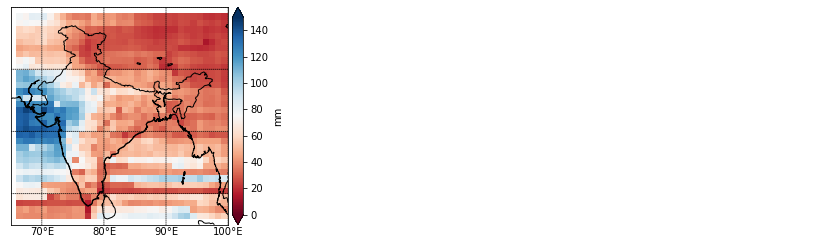

In [21]:
aaaa = spatial_ind(CDD_annualy,bcsd_gcm_01)
map_plot_cyl(aaaa,lat_obs_in,lon_obs_in,map_bounds,'mm','RdBu',[0,150],ax,subplot_iter=d+1)


In [23]:
train_length = np.load(path_out + '/data_gcm_'+gcm_name+'_imd_train.npy').shape[0]
train_length

9855

In [24]:
bcsd_gcm_01.shape

(19710, 33, 35)

In [25]:
data_train = bcsd_gcm_01[:train_length]
data_test = bcsd_gcm_01[train_length:]


In [26]:
print(imd_train.shape,
      imd_test.shape,
      data_gf_train.shape,
      data_gf_test.shape,
      data_train.shape,
      data_test.shape,
     )
      

(9855, 33, 35) (9855, 33, 35) (9855, 33, 35) (9855, 33, 35) (9855, 33, 35) (9855, 33, 35)


In [27]:
from matplotlib.patches import Rectangle


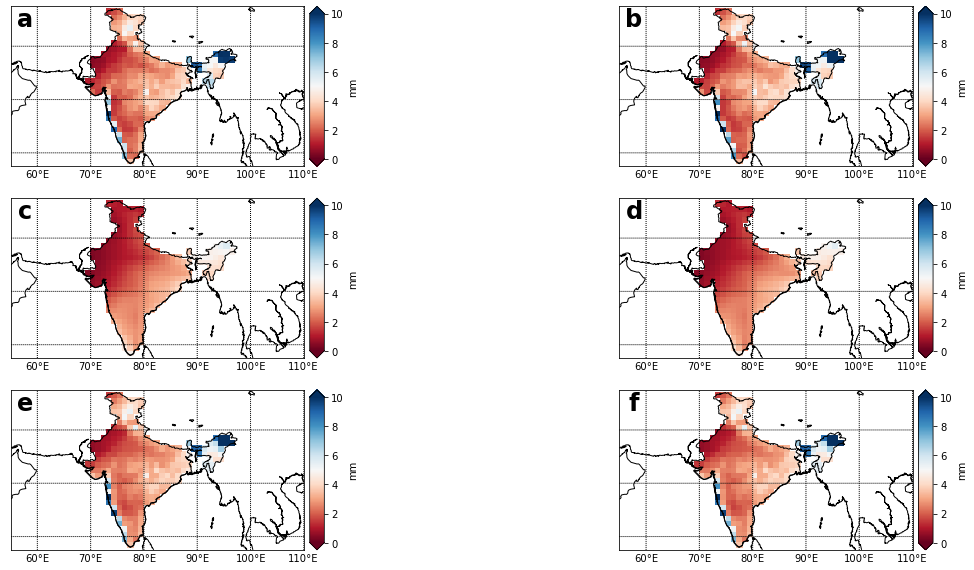

In [28]:
mask_inf=create_mask('/home/vikram/BCSD_Shapefiles/ind.shp',lat_obs_in.data,lon_obs_in.data,buffer=1,plot=0)
map_bounds=[55,37.5,110,7.5]
import numpy.ma as ma
data_in_pre=[imd_train,
      imd_test,
      data_gf_train,
      data_gf_test,
      bcsd_gcm_01,
      bcsd_gcm_01,
     ]

plt.figure(figsize=(20,10))
for d in range(6):
  ax=plt.subplot(3,2,d+1)
  data_x=ma.MaskedArray(np.mean(data_in_pre[d],axis=0),mask=mask_inf)
  map_plot_cyl(data_x,lat_obs_in,lon_obs_in,map_bounds,'mm','RdBu',[0,10],ax,subplot_iter=d+1)

#   rect1 = Rectangle(ll, rhx, rhy, facecolor='none',edgecolor='black' )
#   pt1=ax.add_patch(rect1) 
#   pt1.zorder=1
#   pt1.set_lw(2)

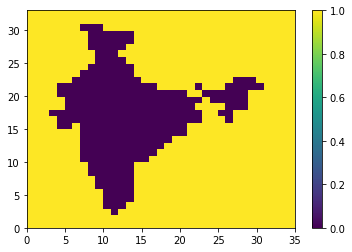

In [29]:
plt.pcolor(mask_inf)
plt.colorbar()

In [30]:
mask_inf[mask_inf >0] = np.nan

In [31]:

def S_score_2D(data_ref, data_model):

    data_1 = data_ref
    data_2 = data_model 
    data_1[mask_inf == True] = np.nan
    data_2[mask_inf == True] = np.nan

    data_1 = data_1.flatten()
    data_2 = data_2.flatten()

    data_1 =  np.delete(data_1,np.isnan(data_1))
    data_2 =  np.delete(data_2,np.isnan(data_2))

    R = np.corrcoef(data_1,data_2)[0,1]

    SDR = np.std(data_2)/np.std(data_1)

    S_score = (1+R)**4  / ( 4 * (SDR + 1 / SDR)**2 )
    
    
    return S_score

In [32]:
data_1 = np.mean(imd_train,axis=0) 
data_2 = np.mean(data_gf_train,axis=0)
data_3 = np.mean(bcsd_gcm_01,axis=0)
print(S_score_2D(data_1,data_2),S_score_2D(data_1,data_3))

0.3982510572521377 0.9645961475108221


In [33]:
data_1 = np.mean(imd_test,axis=0) 
data_2 = np.mean(data_gf_test,axis=0)
data_3 = np.mean(data_test,axis=0)
print(S_score_2D(data_1,data_2),S_score_2D(data_1,data_3))

0.35037507233905096 0.9617465081125872


In [34]:
def spatial_ind(func,data_all):
  
    _,N1,N2 =data_all.shape
    R20_all=np.zeros((N1,N2))
    for i in range(N1):
        for j in range(N2):
            R20_all[i,j]=np.mean(func(data_all[:,i,j],1951,1951+27))
    return R20_all

In [35]:
data_1.shape

(33, 35)

In [36]:
data_1=spatial_ind(CDD_annualy_ly,imd_train)
data_2=spatial_ind(CDD_annualy_ly,data_gf_train)
data_3=spatial_ind(CDD_annualy_ly,bcsd_gcm_01)
print(S_score_2D(data_1,data_2),S_score_2D(data_1,data_3))

0.6982049708205856 0.7950303790189471


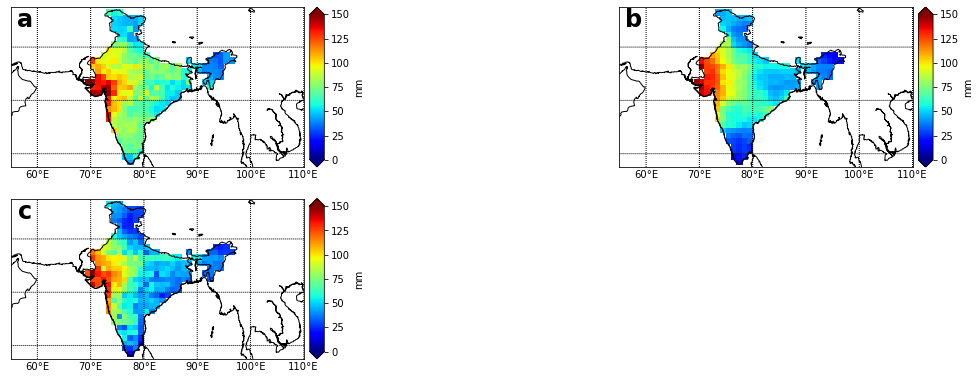

In [37]:
data_in_pre=[data_1,
      data_2,
      data_3,
     ]

plt.figure(figsize=(20,10))
for d in range(3):
  ax=plt.subplot(3,2,d+1)
  data_x=ma.MaskedArray(data_in_pre[d],mask=mask_inf)
  map_plot_cyl(data_x,lat_obs_in,lon_obs_in,map_bounds,'mm','jet',[0,150],ax,subplot_iter=d+1)


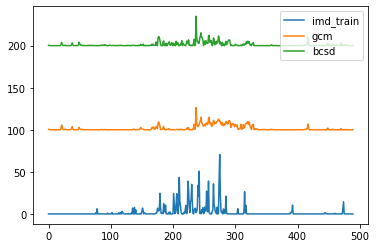

In [41]:
plt.plot(imd_train[710:1200,15,15])
plt.plot(data_gf_train[710:1200,15,15]+100)
plt.plot(data_train[710:1200,15,15]+200)
plt.legend(['imd_train','gcm','bcsd'])

In [39]:
bc_gcm_01=uu.correct_nan_inf_neg(np.load(path_out + '/aBC_outputs_full_'+out_id+'.npy'))
data_123=spatial_ind(mean_sp_annualy_ly,bc_gcm_01)
map_plot_cyl(data_123,lat_gcm_01,lon_gcm_01,map_bounds,'mm','RdBu',[0,10],ax,subplot_iter=d+1)


FileNotFoundError: [Errno 2] No such file or directory: '/home/vikram/BCSD_data/India_P_CH//aBC_outputs_full_gcm_CanESM2_imd.npy'

In [39]:
CDD_indic.shape

NameError: name 'CDD_indic' is not defined

In [180]:
with np.load('./walker.npz',allow_pickle=True) as dataz:
    link_obs = dataz['link_obs'].flatten()
    link_gcm = dataz['link_gcm'].flatten()
    link_ubc = dataz['link_ubc'].flatten()
    
    # link_obs = np.any(dataz['link_obs'],axis= 2).flatten()
    # link_gcm = np.any(dataz['link_gcm'],axis= 2).flatten()
    # link_ubc = np.any(dataz['link_ubc'],axis= 2).flatten()

    

In [105]:
link_obs

array([False,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False,  True, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False])

In [106]:
from sklearn.metrics import f1_score

f1_score(link_obs,link_obs)

1.0

In [148]:
f1_score(link_obs,link_ubc)

0.6666666666666666